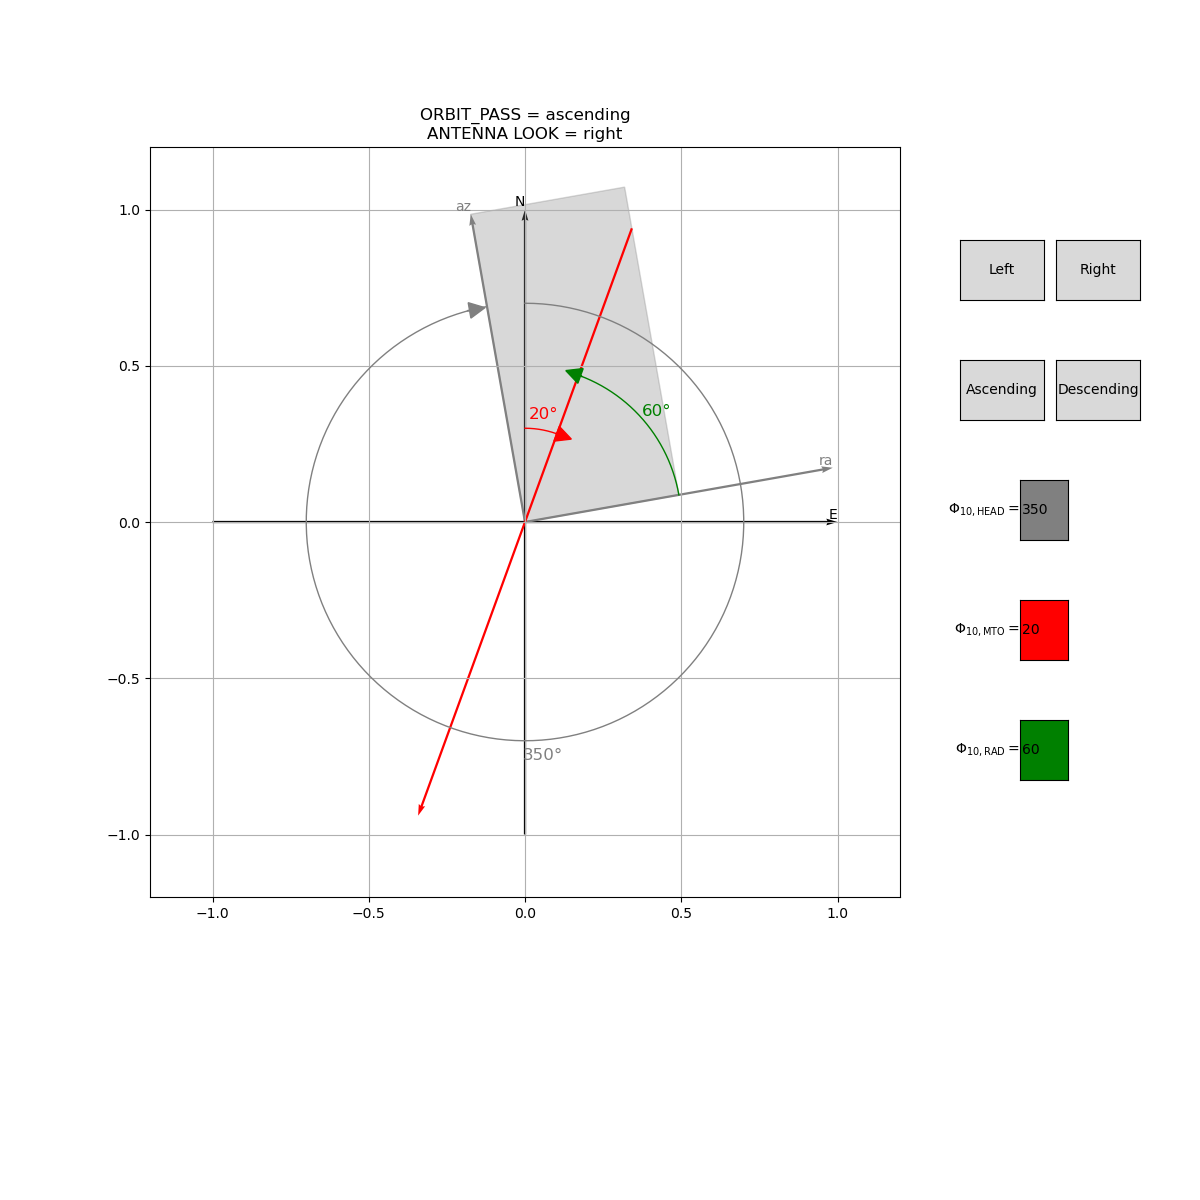

In [7]:
import numpy as np 
import xsarsea 
from plot_tools import draw_vector, draw_angle

from matplotlib.patches import Rectangle
from matplotlib.widgets import TextBox, Button
import matplotlib.pyplot as plt 
#plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering



ORBIT_PASS = "ascending"
ANTENNA_LOOK = "right"
COLOR_RADAR = 'gray'
COLOR_WIND_RADAR = 'green'
COLOR_WIND_METEO = 'red'
COLOR_NE = 'black'

def update_heading(val):
    """
    Update the heading angle and the corresponding radar and azimuth vectors
    Update the SAR rectangle
    
    Parameters
    ----------
    val : str
        The new value of the heading angle in degrees in meteo convention
    
    Results
    -------
    None
    """
    global arc_heading, arrow_heading, text_heading
    # Remove the old arrow and arc
    arc_heading.remove()
    arrow_heading.remove()
    text_heading.remove()
    
    heading_initial = int(val)
    heading_current = 360 - heading_initial
    heading_rad = np.radians(heading_current)
    if (ANTENNA_LOOK == 'right'):
        base_range = [np.cos(heading_rad), np.sin(heading_rad)]
        base_az = [-np.sin(heading_rad), np.cos(heading_rad)]
    elif (ANTENNA_LOOK == 'left'):
        base_range = [-np.cos(heading_rad), -np.sin(heading_rad)]
        base_az = [-np.sin(heading_rad), np.cos(heading_rad)]
    

    vec_range.set_UVC(*base_range)
    vec_az.set_UVC(*base_az)
    end_range = np.array([0, 0]) + np.array(base_range)
    end_az = np.array([0, 0]) + np.array(base_az)
    label_range.set_position((end_range[0], end_range[1]))
    label_az.set_position((end_az[0], end_az[1]))

    arc_heading, arrow_heading, text_heading = draw_angle(ax, [0, 0], 90, heading_initial, radius=0.7, color=COLOR_RADAR, clockwise=True)
    update_winddir_antenna()
    update_rectangle_sar()    
    fig.canvas.draw_idle()
    

def update_winddir_meteo(val):      
    """
    Update the winddir in meteo convention 
    Update the winddir in antenna convention
    
    Parameters
    ----------
    val : str
        The new value of the wind direction in degrees in meteo convention
    
    Results
    -------
    None
    """  
    global arc_winddir, arrow_winddir, text_winddir, vec_meteo ,label_meteo
    # Remove the old arrow and arc
    arc_winddir.remove()
    arrow_winddir.remove()
    text_winddir.remove()
    vec_meteo.remove()
    winddir_meteo_initial = int(val)
    winddir_current = 90 - winddir_meteo_initial - 180 
    winddir_meteo_rad = np.radians(winddir_current)
    base_meteo = [np.cos(winddir_meteo_rad), np.sin(winddir_meteo_rad)]
    vec_meteo, label_meteo = draw_vector(ax, [0,0], base_meteo, COLOR_WIND_METEO, None, True)

    arc_winddir, arrow_winddir, text_winddir= draw_angle(ax, [0, 0], 90, winddir_meteo_initial, radius=0.3, color=COLOR_WIND_METEO, clockwise=True)  # Arc starting from North
    update_winddir_antenna()
    fig.canvas.draw_idle()
    

def update_winddir_antenna():
    """
    Update the wind direction in antenna convention
    
    Parameters
    ----------
    None
    
    Results
    -------
    None
    """
    global arc_antenna, arrow_antenna, text_antenna
    # Remove the old arrow and arc
    arc_antenna.remove()
    arrow_antenna.remove()
    text_antenna.remove()

    winddir_meteo = int(text_box_winddir.text) 
    heading_meteo = int(text_box_heading.text)  
    heading_python = 360 - heading_meteo

    result = int(xsarsea.dir_to_360(np.degrees(xsarsea.dir_meteo_to_sample(winddir_meteo, heading_meteo))))
    arc_antenna, arrow_antenna, text_antenna= draw_angle(ax, [0, 0], heading_python, result, radius=0.5, color= COLOR_WIND_RADAR,  clockwise=False)  # Arc starting from North

    text_box_winddir_antenna.set_val(str(result))
    fig.canvas.draw_idle()

def update_rectangle_sar():
    """
    Update the SAR rectangle
    
    Parameters
    ----------
    None
    
    Results
    -------
    None
    """
    global patch_rec_sar
    patch_rec_sar.remove()

    if (ANTENNA_LOOK == 'right'):
        base_range = [np.cos(heading_rad), np.sin(heading_rad)]
        base_az = [-np.sin(heading_rad), np.cos(heading_rad)]
        # Ajout du rectangle
        patch_rec_sar = Rectangle(
            (0, 0),
            0.5,
            1.0,
            angle=-int(text_box_heading.text),
            color='gray',
            alpha=0.3
        )
        patch_reg_sar = ax.add_patch(patch_rec_sar)
    
    elif (ANTENNA_LOOK == 'left'):
        base_range = [-np.cos(heading_rad), -np.sin(heading_rad)]
        base_az = [-np.sin(heading_rad), np.cos(heading_rad)]
        # Ajout du rectangle
        patch_rec_sar = Rectangle(
            (0, 0),
            -0.5,
            1.0,
            angle=-int(text_box_heading.text),
            color='gray',
            alpha=0.3
        )
        patch_reg_sar = ax.add_patch(patch_rec_sar)
    
    fig.canvas.draw_idle()

def update_view():
    update_heading()
    ax.set_title(f"ORBIT PASS = {ORBIT_PASS}\nANTENNA LOOK = {ANTENNA_LOOK}")
    fig.canvas.draw_idle()

def left_button_clicked(event):
    global ANTENNA_LOOK
    ANTENNA_LOOK = "left"
    update_view()

def right_button_clicked(event):
    global ANTENNA_LOOK
    ANTENNA_LOOK = "right"
    update_view()

def button_ascending_clicked(event):
    global ORBIT_PASS
    ORBIT_PASS = "ascending"
    text_box_heading.set_val(350)
    update_view()

def button_descending_clicked(event):
    global ORBIT_PASS
    ORBIT_PASS = "descending"
    text_box_heading.set_val(190)
    update_view()



if __name__ == "__main__":
    %matplotlib widget

    #Define figure
    fig, ax = plt.subplots(figsize=(12,12))
    plt.subplots_adjust(bottom=0.25, right=0.75)  # Adjust for slider and figure space

    #Define axes limits and grid
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.grid(True)

    #Plot NE vectors
    east_vector = [1, 0]
    north_vector = [0, 1]
    vec_e, label_e = draw_vector(ax, [0, 0], east_vector, COLOR_NE, 'E', extend = True)
    vec_n, label_n = draw_vector(ax, [0, 0], north_vector, COLOR_NE, 'N',extend = True)

    #Initiate and plot heading angle 
    heading_initial = 350
    heading_python = - heading_initial #same as 360 - heading_initial
    heading_rad = np.radians(heading_python)

    if (ANTENNA_LOOK == 'right'):
        base_range = [np.cos(heading_rad), np.sin(heading_rad)]
        base_az = [-np.sin(heading_rad), np.cos(heading_rad)]
        patch_rec_sar = Rectangle(
            (0, 0),
            0.5,
            1.0,
            angle=-heading_initial,
            color='gray',
            alpha=0.3
        )
        patch_reg_sar = ax.add_patch(patch_rec_sar)

    elif (ANTENNA_LOOK == 'left'):
        base_range = [-np.cos(heading_rad), -np.sin(heading_rad)]
        base_az = [-np.sin(heading_rad), np.cos(heading_rad)]
        # Plot SAR rectangle
        patch_rec_sar = Rectangle(
            (0, 0),
            -0.5,
            1.0,
            angle=-heading_initial,
            color='gray',
            alpha=0.3
        )
        patch_reg_sar = ax.add_patch(patch_rec_sar)


    vec_range, label_range = draw_vector(ax, [0, 0], base_range, COLOR_RADAR, 'ra')
    vec_az, label_az = draw_vector(ax, [0, 0], base_az, COLOR_RADAR, 'az')

    #Initiate and plot winddir_meteo angle 
    winddir_meteo_initial = 20
    winddir_meteo_python = 90 - winddir_meteo_initial - 180
    winddir_meteo_rad = np.radians(winddir_meteo_python)
    base_meteo = [np.cos(winddir_meteo_rad), np.sin(winddir_meteo_rad)]
    vec_meteo, label_meteo = draw_vector(ax, [0,0], base_meteo, COLOR_WIND_METEO, None, True)

    # Draw arc and angles 
    winddir_antenna_initial = int(xsarsea.dir_to_360(np.degrees(xsarsea.dir_meteo_to_sample(winddir_meteo_initial, heading_initial))))
    arc_heading, arrow_heading, text_heading = draw_angle(ax, [0, 0], 90, heading_initial, radius=0.7, color=COLOR_RADAR, clockwise=True)  # Arc starting from North
    arc_winddir, arrow_winddir, text_winddir= draw_angle(ax, [0, 0], 90, winddir_meteo_initial, radius=0.3, color='red', clockwise=True)  # Arc starting from North
    arc_antenna, arrow_antenna, text_antenna= draw_angle(ax, [0, 0], heading_python, winddir_antenna_initial, radius=0.5, color=COLOR_WIND_RADAR, clockwise=False)  # Arc starting from North

    # TextBoxes for manual modifications 
    text_box_ax_heading = plt.axes([0.85, 0.55, 0.04, 0.05])
    text_box_heading = TextBox(text_box_ax_heading, r'$\Phi_{10, \mathrm{HEAD}} =$', initial=str(heading_initial),color=COLOR_RADAR)
    text_box_heading.on_submit(update_heading)

    text_box_ax_winddir = plt.axes([0.85, 0.45, 0.04, 0.05])
    text_box_winddir = TextBox(text_box_ax_winddir, r'$\Phi_{10, \mathrm{MTO}} =$', initial=str(winddir_meteo_initial), color="red")
    text_box_winddir.on_submit(update_winddir_meteo)

    text_box_ax_winddir_antenna = plt.axes([0.85, 0.35, 0.04, 0.05])  # Adjust size and location as needed
    text_box_winddir_antenna = TextBox(text_box_ax_winddir_antenna, r'$\Phi_{10, \mathrm{RAD}} =$', initial=str(winddir_antenna_initial), color = COLOR_WIND_RADAR)
    text_box_winddir_antenna.set_active(False)  # Rendre la boîte de texte non modifiable

    # Buttons for selecting antenna look direction
    button_ax_left = plt.axes([0.8, 0.75, 0.07, 0.05])
    button_left = Button(button_ax_left, 'Left')
    button_left.on_clicked(left_button_clicked)

    button_ax_right = plt.axes([0.88, 0.75, 0.07, 0.05])
    button_right = Button(button_ax_right, 'Right')
    button_right.on_clicked(right_button_clicked)

    # Buttons for selecting pass
    button_ax_ascending = plt.axes([0.8, 0.65, 0.07, 0.05])
    button_ascending = Button(button_ax_ascending, 'Ascending')
    button_ascending.on_clicked(button_ascending_clicked)

    button_ax_descending = plt.axes([0.88, 0.65, 0.07, 0.05])
    button_descending = Button(button_ax_descending, 'Descending')
    button_descending.on_clicked(button_descending_clicked)


    ax.set_title(f"ORBIT_PASS = {ORBIT_PASS}\nANTENNA LOOK = {ANTENNA_LOOK}")

    plt.show()